<a href="https://colab.research.google.com/github/staerkjoe/ML_colab/blob/main/CreditRisk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Risk Data Set
## Set up Data

https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data

In [14]:
pip install ucimlrepo

In [15]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
import wandb
from types import SimpleNamespace

In [16]:
# fetch dataset
statlog_german_credit_data = fetch_ucirepo(id=144)

# data (as pandas dataframes)
X = statlog_german_credit_data.data.features
y = statlog_german_credit_data.data.targets

df = pd.concat([X, y], axis=1)

In [17]:
df.head()

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,...,Attribute12,Attribute13,Attribute14,Attribute15,Attribute16,Attribute17,Attribute18,Attribute19,Attribute20,class
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [18]:
attribute_mapping = {
    "Attribute1": "checking_status",        # Status of existing checking account
    "Attribute2": "duration",              # Duration (months)
    "Attribute3": "credit_history",        # Credit history
    "Attribute4": "purpose",               # Purpose
    "Attribute5": "credit_amount",         # Credit amount
    "Attribute6": "savings",               # Savings account/bonds
    "Attribute7": "employment",            # Present employment since
    "Attribute8": "installment_rate",      # Installment rate in % of disposable income
    "Attribute9": "personal_status_sex",   # Personal status and sex
    "Attribute10": "other_debtors",        # Other debtors / guarantors
    "Attribute11": "residence_since",      # Present residence since
    "Attribute12": "property",             # Property
    "Attribute13": "age",                  # Age (years)
    "Attribute14": "other_installment",    # Other installment plans
    "Attribute15": "housing",              # Housing
    "Attribute16": "existing_credits",     # Number of existing credits at this bank
    "Attribute17": "job",                  # Job
    "Attribute18": "people_liable",        # Number of people liable to provide maintenance
    "Attribute19": "telephone",            # Telephone
    "Attribute20": "foreign_worker",       # Foreign worker
    "class": "credit_risk"                 # Target: 1 = Good, 2 = Bad
}

# Apply mapping
df = df.rename(columns=attribute_mapping)


In [19]:
# target varibale --> 0 = bad, 1 = good
df["credit_risk"] = df["credit_risk"].map({1: 1, 2: 0})
df["credit_per_duration"] = df["credit_amount"] / (df["duration"] + 1)
df["credit_per_age"] = df["credit_amount"] / (df["age"] + 1)
df["credit_per_existing"] = df["credit_amount"] / (df["existing_credits"] + 1)

In [20]:
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings,employment,installment_rate,personal_status_sex,other_debtors,...,housing,existing_credits,job,people_liable,telephone,foreign_worker,credit_risk,credit_per_duration,credit_per_age,credit_per_existing
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A152,2,A173,1,A192,A201,1,167.000000,17.191176,389.666667
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A152,1,A173,1,A191,A201,0,121.448980,258.739130,2975.500000
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A152,1,A172,2,A191,A201,1,161.230769,41.920000,1048.000000
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A153,1,A173,2,A191,A201,1,183.302326,171.347826,3941.000000
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A153,2,A173,2,A191,A201,0,194.800000,90.185185,1623.333333


In [21]:
# Identify categorical vs numerical
ordinal_features = ["checking_status", "credit_history", "savings", "employment", "job"]

nominal_features = ["purpose", "personal_status_sex", "other_debtors", "property", "other_installment", "housing", "telephone", "foreign_worker"]

num_features = ["duration","credit_amount","installment_rate","residence_since", "age","existing_credits","people_liable","credit_per_existing","credit_per_age","credit_per_duration"]

## EDA

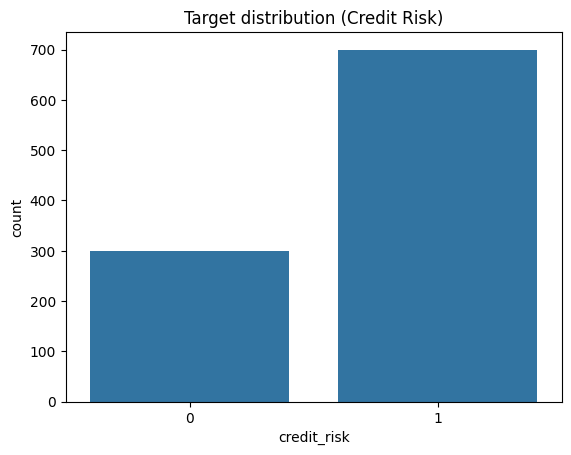

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="credit_risk", data=df)
plt.title("Target distribution (Credit Risk)")
plt.show()

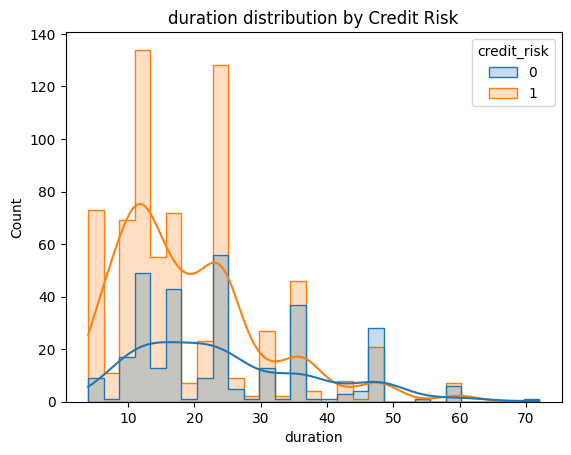

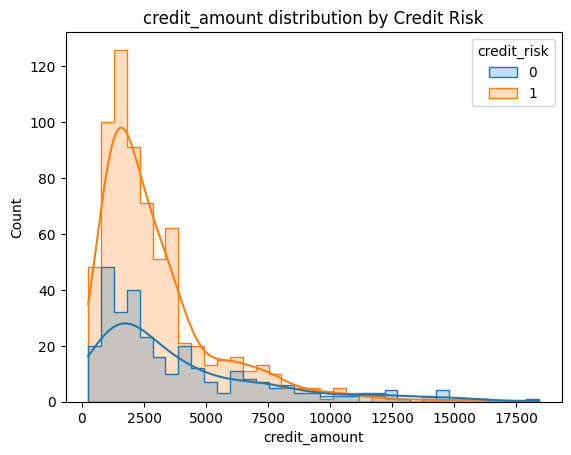

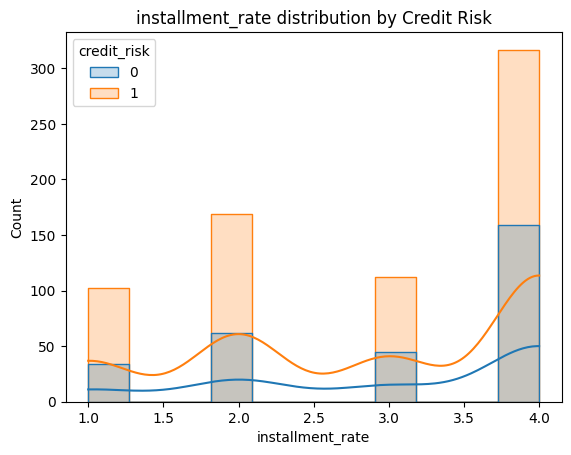

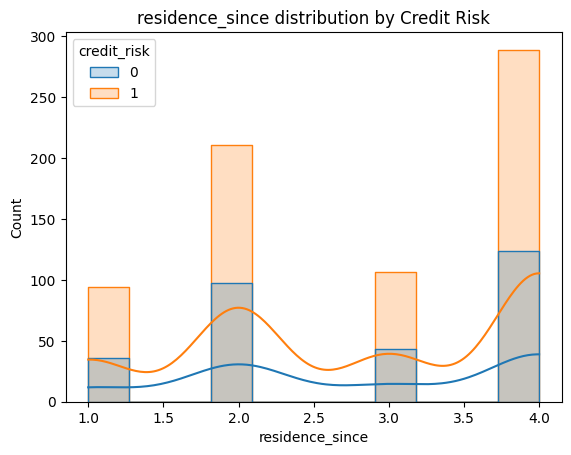

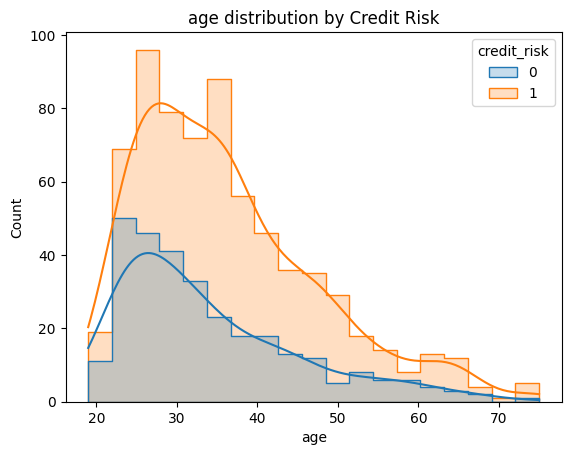

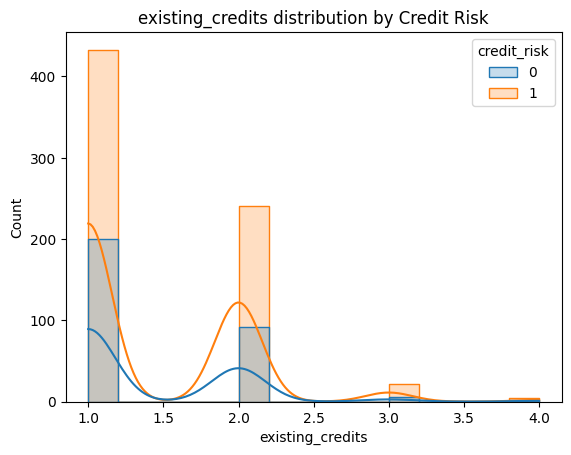

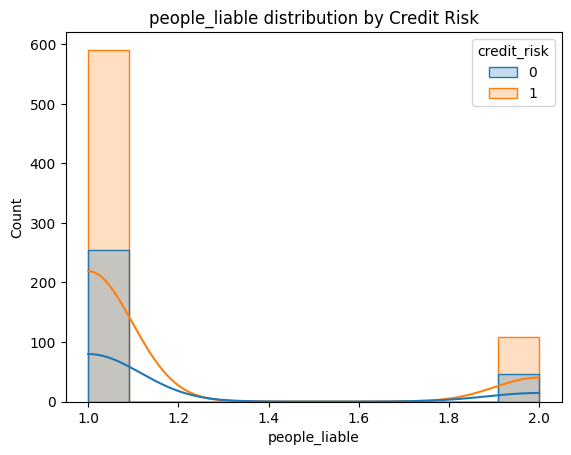

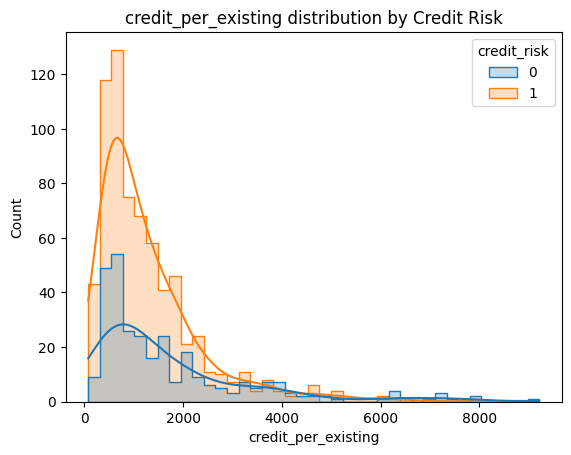

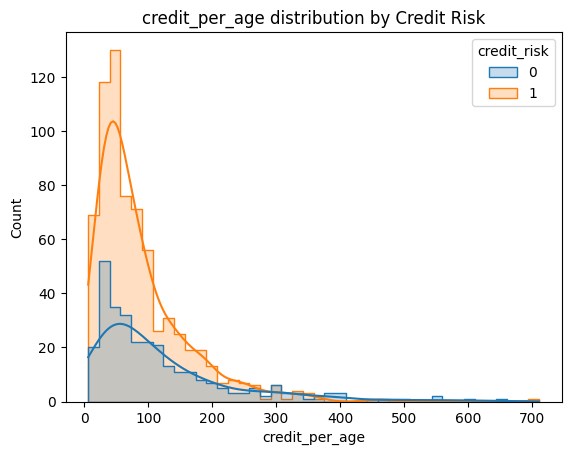

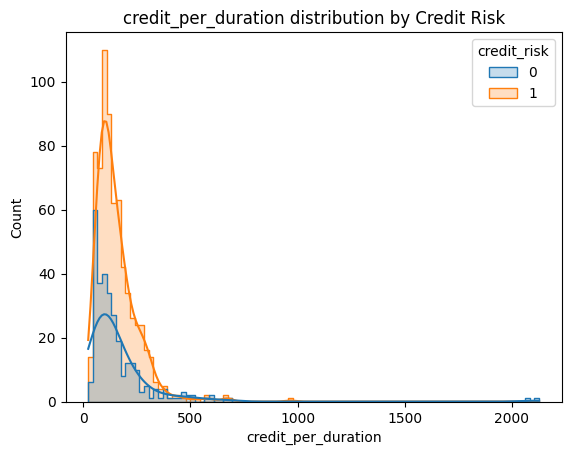

In [23]:
for col in num_features:
    plt.figure()
    sns.histplot(data=df, x=col, hue="credit_risk", kde=True, element="step")
    plt.title(f"{col} distribution by Credit Risk")
    plt.show()

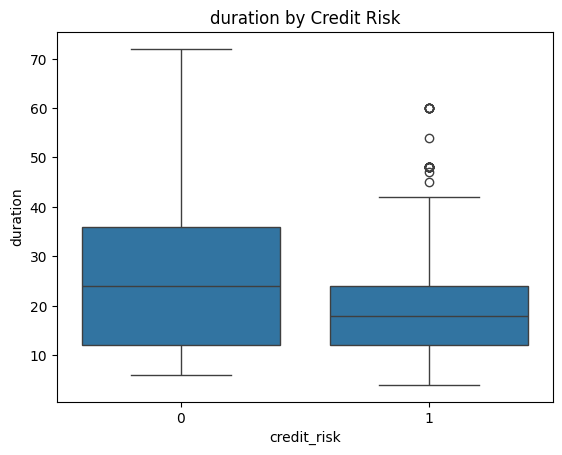

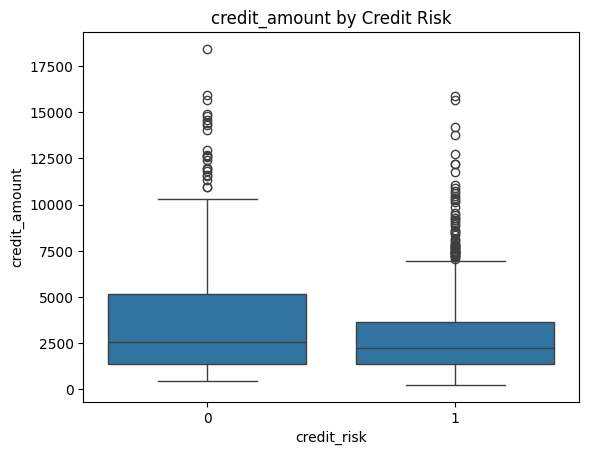

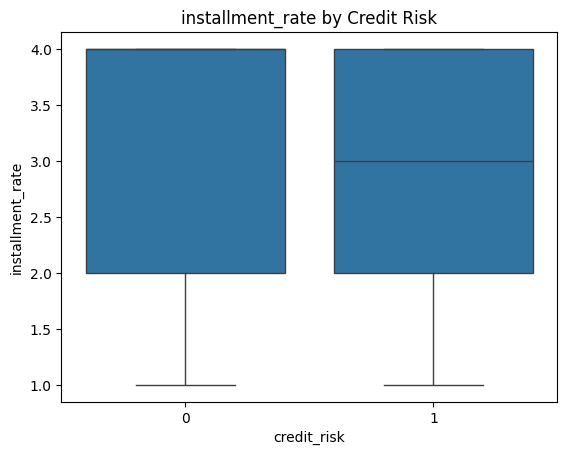

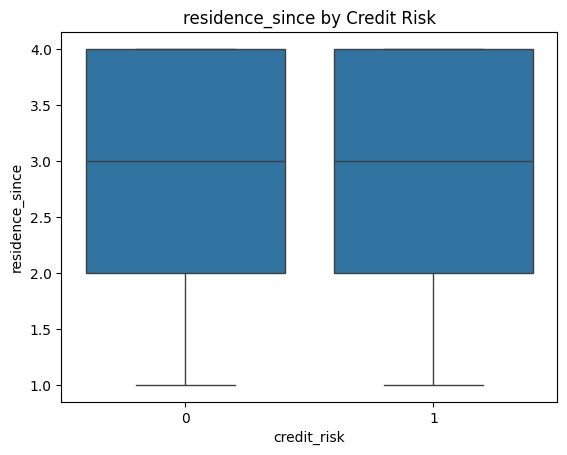

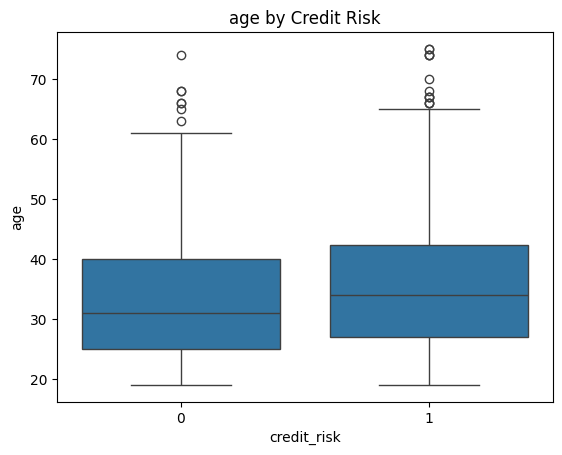

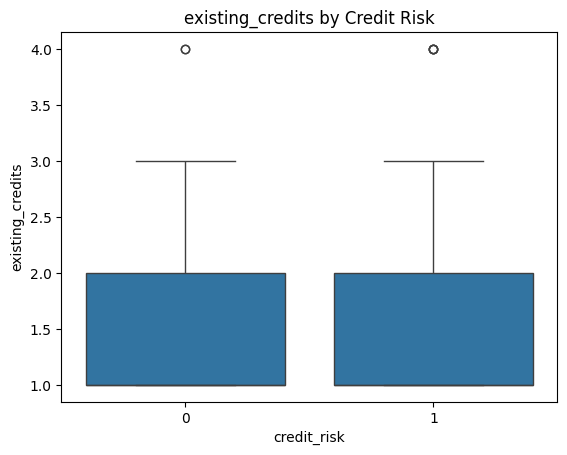

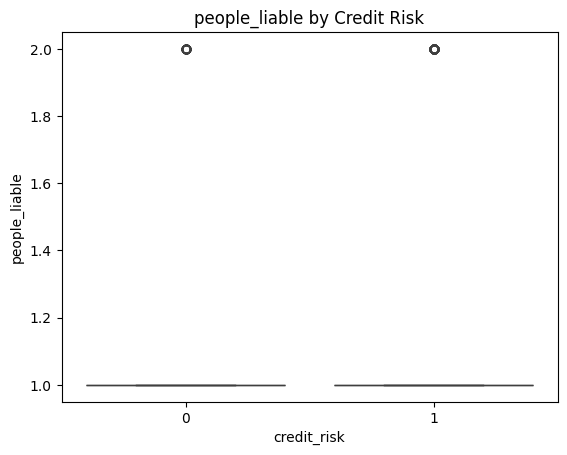

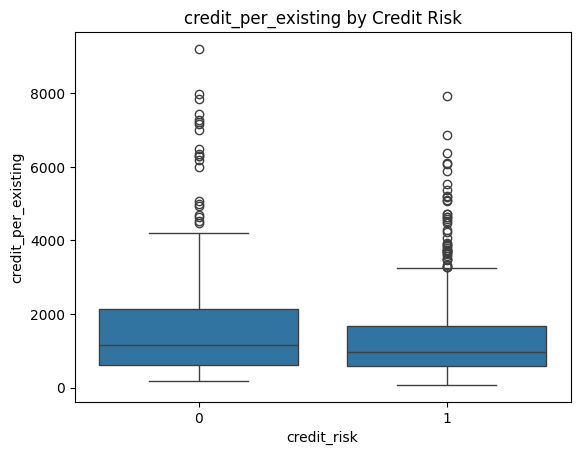

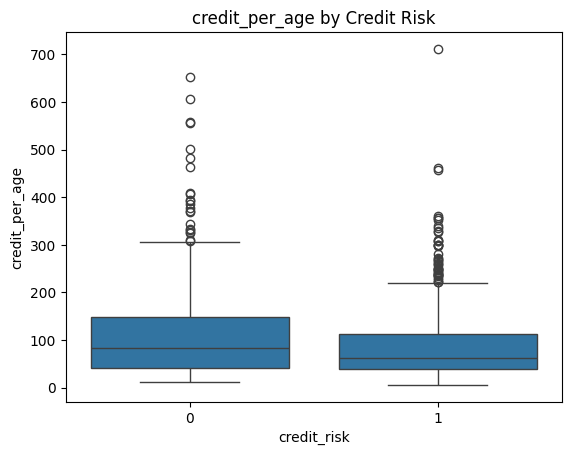

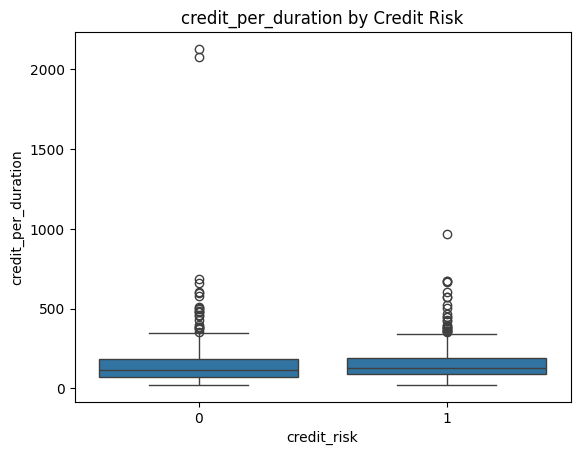

In [24]:
for col in num_features:
    plt.figure()
    sns.boxplot(x="credit_risk", y=col, data=df)
    plt.title(f"{col} by Credit Risk")
    plt.show()

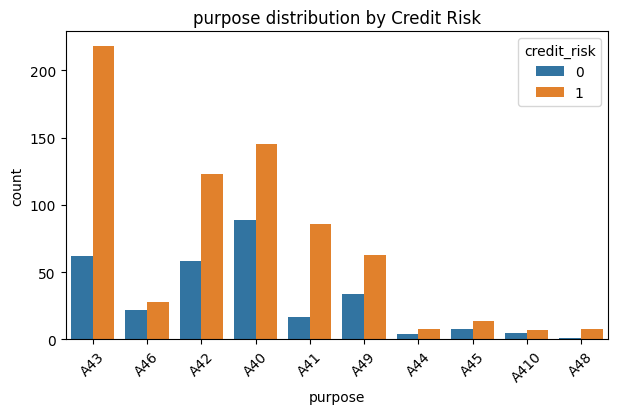

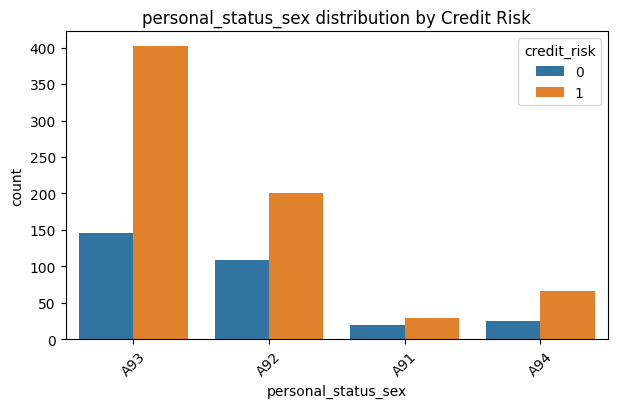

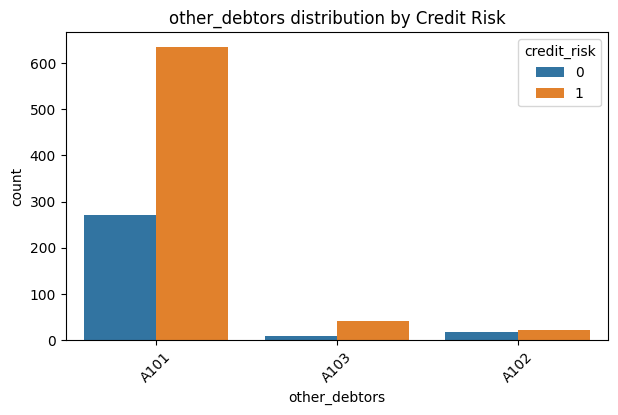

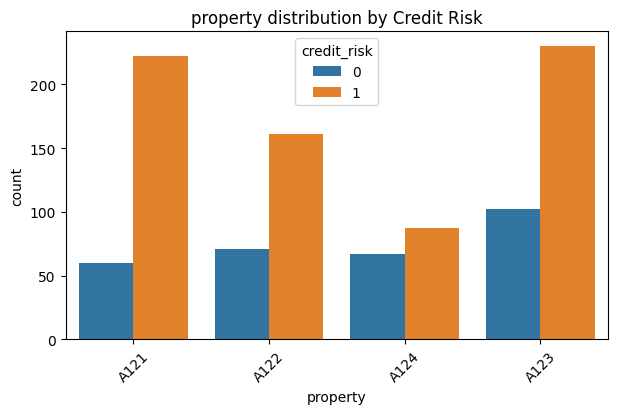

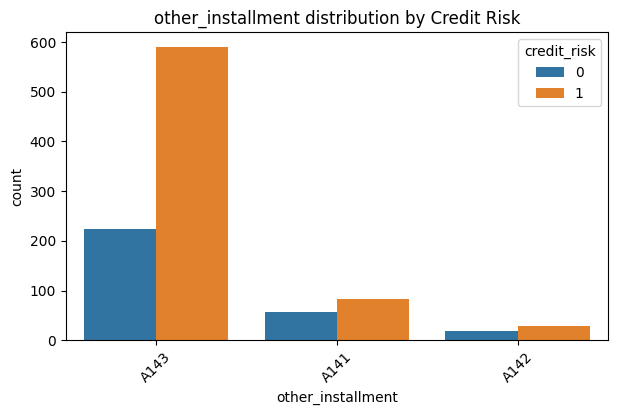

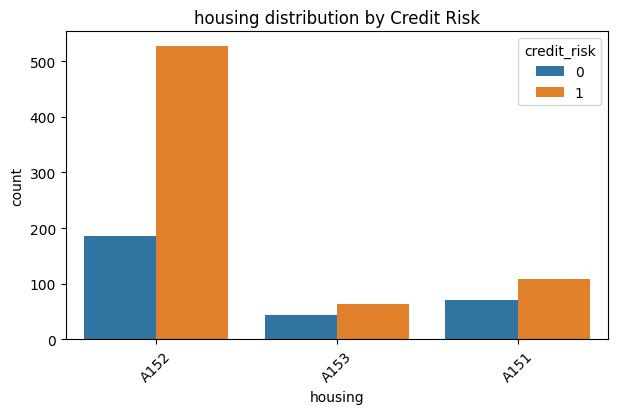

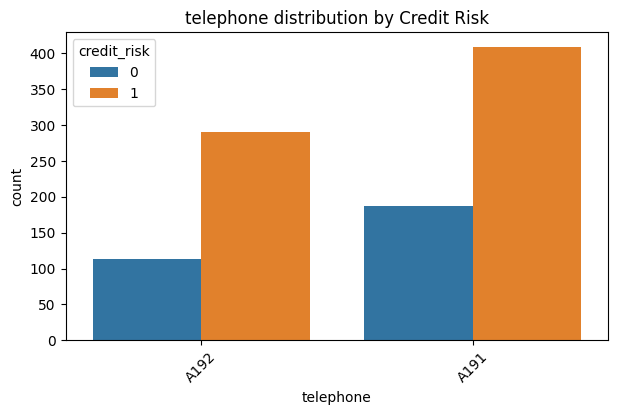

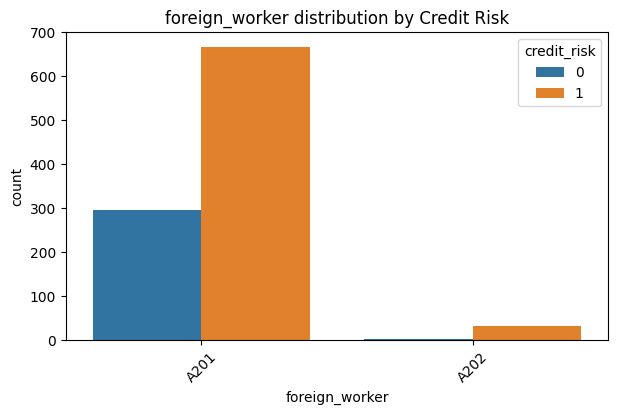

In [25]:
for col in nominal_features:
    plt.figure(figsize=(7,4))
    sns.countplot(x=col, hue="credit_risk", data=df)
    plt.title(f"{col} distribution by Credit Risk")
    plt.xticks(rotation=45)
    plt.show()

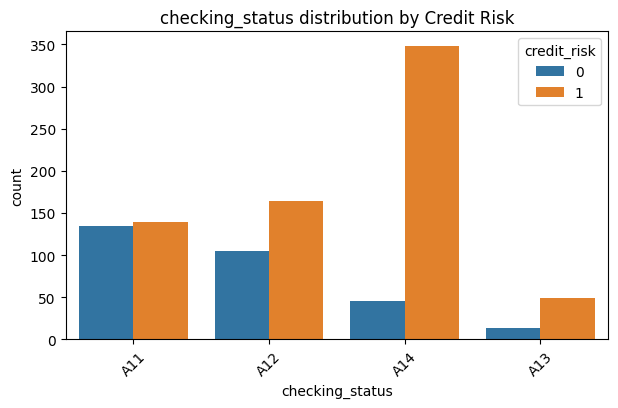

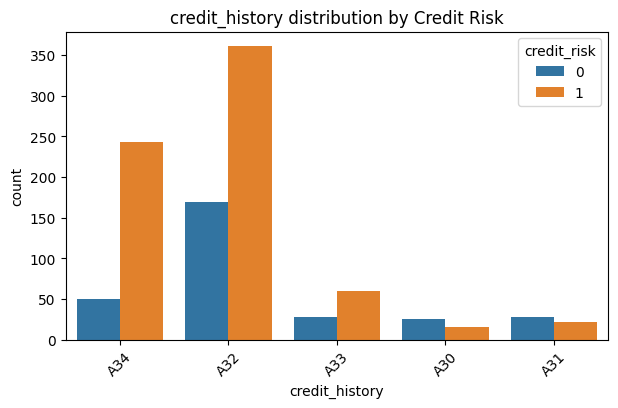

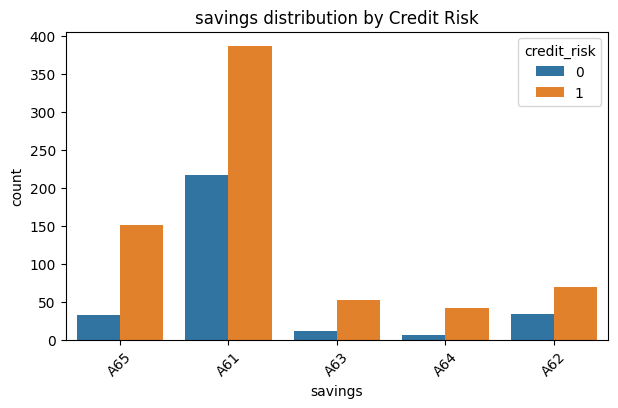

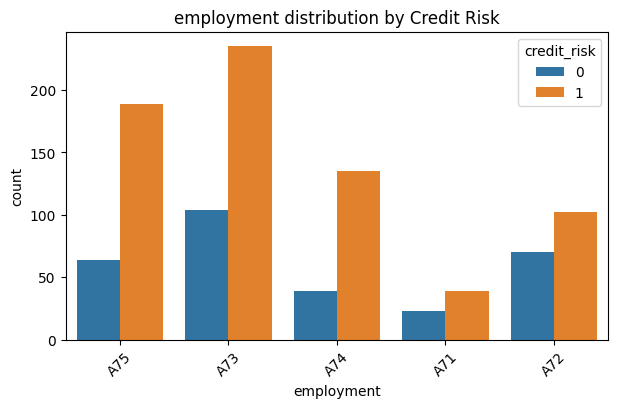

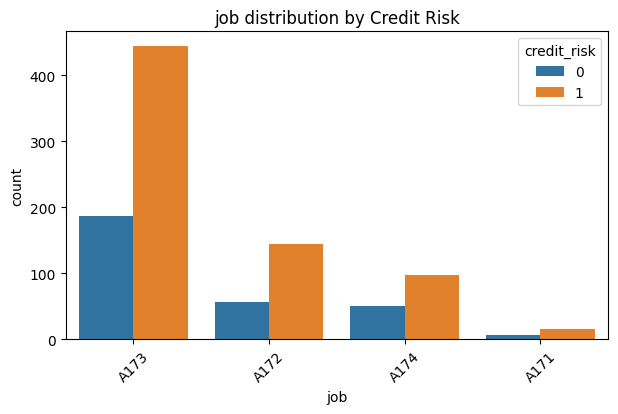

In [26]:
for col in ordinal_features:
    plt.figure(figsize=(7,4))
    sns.countplot(x=col, hue="credit_risk", data=df)
    plt.title(f"{col} distribution by Credit Risk")
    plt.xticks(rotation=45)
    plt.show()

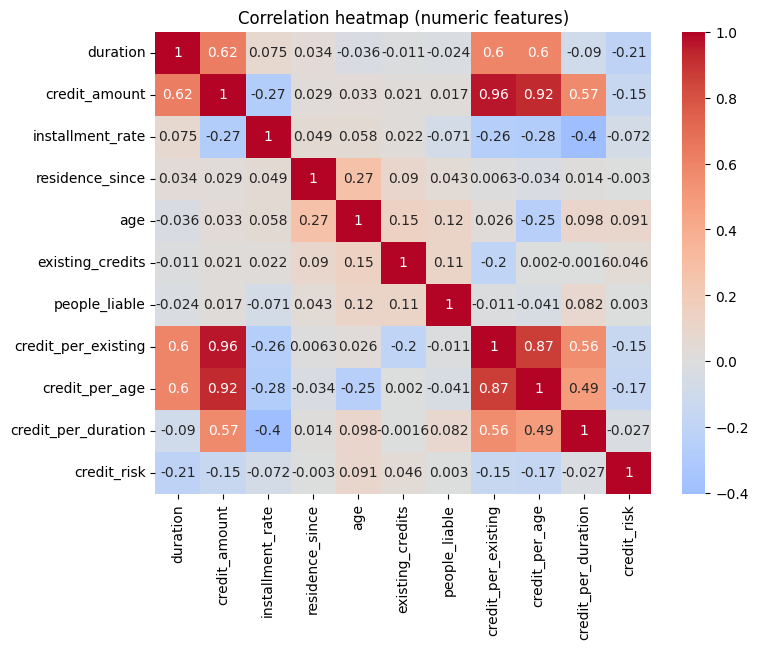

In [27]:
plt.figure(figsize=(8,6))
sns.heatmap(df[num_features + ["credit_risk"]].corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation heatmap (numeric features)")
plt.show()

## Models

In [28]:
from sklearn.model_selection import train_test_split, GridSearchCV

X = df.drop("credit_risk", axis=1)
y = df["credit_risk"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=19
)

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import OrdinalEncoder

In [30]:
# Transformers
preprocessor_logreg = ColumnTransformer([
    ("nominal", OneHotEncoder(handle_unknown="ignore"), nominal_features),
    ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), ordinal_features),
    ("num", StandardScaler(), num_features)
])


logreg_pipeline = ImbPipeline(steps=[
    ("preprocess", preprocessor_logreg),
    ("smote", SMOTE(random_state=42)),
    ("clf", LogisticRegression(max_iter=1000, solver="liblinear"))
])


# GridSearch hyperparameters

param_grid = {
    "clf__penalty": ["l1", "l2", "elasticnet"],
    "clf__C": [0.0001, 0.001, 0.01, 0.1, 1, 10],
    "clf__solver": ["liblinear", "saga"],
    "clf__l1_ratio": [0.2, 0.5, 0.8]  # only used if penalty="elasticnet"
}

grid_search = GridSearchCV(
    logreg_pipeline,
    param_grid,
    cv=5,
    scoring="f1",   # or "roc_auc", depending on your goal
    n_jobs=-1
)


# 6. Fit & Evaluate

grid_search.fit(X_train, y_train)


print("Best params:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)
print("Test score:", grid_search.score(X_test, y_test))

Best params: {'clf__C': 0.0001, 'clf__l1_ratio': 0.2, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Best CV score: 0.8299265074479443
Test score: 0.8301886792452831


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
90 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/imblearn/pipeline.py", line 526, in fit
    self._final_estimator.fit(Xt, yt, *

In [31]:
# Initialize W&B run
run = wandb.init(project="QuantRiskNew", name="logreg_run1", tags=["logreg","SMOTE"])
wandb.config.update(grid_search.best_params_)

Train Accuracy: 0.7362
Test Accuracy: 0.7300
Train F1: 0.8353
Test F1: 0.8302
Precision: 0.7416
Recall: 0.9429
ROC-AUC: 0.7930


Precision,▁
ROC-AUC,▁
Recall,▁
Test Accuracy,▁
Test F1,▁
Train Accuracy,▁
Train F1,▁
Precision,0.74157
ROC-AUC,0.79298
Recall,0.94286
Test Accuracy,0.73


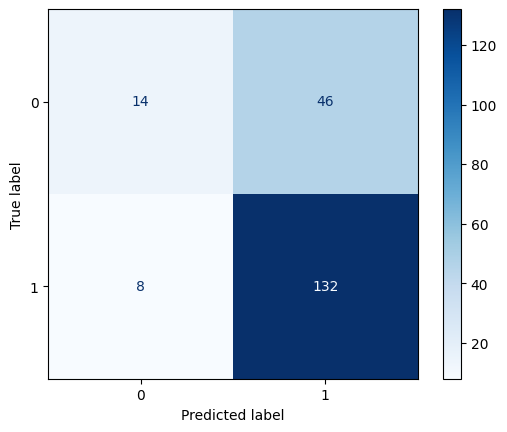

In [32]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import wandb
import wandb.sklearn

# Predict on test set
y_pred_logreg = grid_search.predict(X_test)
y_train_pred_logreg = grid_search.predict(X_train)
y_proba_logreg = grid_search.predict_proba(X_test)[:, 1]  # probability of class 1

# Collect metrics
metrics = {
    "Train Accuracy": accuracy_score(y_train, y_train_pred_logreg),
    "Test Accuracy": accuracy_score(y_test, y_pred_logreg),
    "Train F1": f1_score(y_train, y_train_pred_logreg),
    "Test F1": f1_score(y_test, y_pred_logreg),
    "Precision": precision_score(y_test, y_pred_logreg),
    "Recall": recall_score(y_test, y_pred_logreg),
    "ROC-AUC": roc_auc_score(y_test, y_proba_logreg)
}

# Print metrics in a loop
for name, value in metrics.items():
    print(f"{name}: {value:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_logreg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.classes_)
disp.plot(cmap="Blues")


wandb.sklearn.plot_confusion_matrix(y_test, y_pred_logreg, ["bad", "good"])
wandb.log(metrics)
wandb.finish()

## XGBoost

In [33]:
from sklearn.preprocessing import OrdinalEncoder

preprocessor_tree = ColumnTransformer([
    ("nominal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), nominal_features),
    ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), ordinal_features),
    ("num", "passthrough", num_features)  # no scaling needed
])

In [34]:
from xgboost import XGBClassifier

xgb_pipeline = ImbPipeline(steps=[
    ("preprocess", preprocessor_tree),   # your encoder/transformer
    #("smote", SMOTE(random_state=42)),
    ("clf", XGBClassifier(
        enable_categorical=True,
        eval_metric="logloss",
        tree_method="gpu_hist",   # GPU acceleration
        predictor="gpu_predictor", # ensure GPU is used for inference
        random_state=42
    ))
])

In [35]:
# 5. GridSearch hyperparameters
from sklearn.model_selection import RandomizedSearchCV

param_grid_xgb = {
    # Boosting rounds
    "clf__n_estimators": [200, 300, 500],

    # Tree complexity
    "clf__max_depth": [3, 5, 7],
    "clf__min_child_weight": [1, 3, 5],   # helps control overfitting

    # Learning rate
    "clf__learning_rate": [0.01, 0.05, 0.1],

    # Row & column sampling (regularization by subsampling)
    "clf__subsample": [0.7, 0.8, 1.0],
    "clf__colsample_bytree": [0.7, 0.9, 1.0],

    # Regularization
    "clf__reg_lambda": [1, 5, 10],   # L2
    "clf__reg_alpha": [0, 0.5, 1],   # L1

    # Optional: gamma for tree split regularization
    "clf__gamma": [0, 0.1, 0.2]
}

'''
grid_search_xgb = GridSearchCV(
    xgb_pipeline,
    param_grid_xgb,
    cv=5,
    scoring="f1",   # or "roc_auc", depending on your goal
    n_jobs=-1,
    verbose=2
)
'''


rand_search_xgb = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=param_grid_xgb,
    n_iter=150,   # number of random combos
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=2,
    random_state=42
)
rand_search_xgb.fit(X_train, y_train)

# 6. Fit & Evaluate

#grid_search_xgb.fit(X_train, y_train)

print("Best params:", rand_search_xgb.best_params_)
print("Best CV score:", rand_search_xgb.best_score_)
print("Test score:", rand_search_xgb.score(X_test, y_test))

Fitting 5 folds for each of 19683 candidates, totalling 98415 fits


KeyboardInterrupt: 

In [ ]:
# Initialize W&B run
run = wandb.init(project="QuantRiskNew", name="xgb_run1", tags=["xgboost","NoSMOTE"])
wandb.config.update(rand_search_xgb.best_params_)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score

y_pred_xgb = rand_search_xgb.predict(X_test)
y_train_pred_xgb = rand_search_xgb.predict(X_train)
y_proba_xgb = rand_search_xgb.predict_proba(X_test)[:, 1]  # probability of class 1

# Collect metrics
metrics = {
    "Train Accuracy": accuracy_score(y_train, y_train_pred_xgb),
    "Test Accuracy": accuracy_score(y_test, y_pred_xgb),
    "Train F1": f1_score(y_train, y_train_pred_xgb),
    "Test F1": f1_score(y_test, y_pred_xgb),
    "Precision": precision_score(y_test, y_pred_xgb),
    "Recall": recall_score(y_test, y_pred_xgb),
    "ROC-AUC": roc_auc_score(y_test, y_proba_xgb)
}

# Print metrics in a loop
for name, value in metrics.items():
    print(f"{name}: {value:.4f}")

cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rand_search_xgb.classes_)
disp.plot(cmap="Blues")


# --- Precision–Recall Curve ---
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_xgb)
ap_score = average_precision_score(y_test, y_proba_xgb)

# Find F1-optimal threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]

print(f"\nBest threshold = {best_threshold:.3f}")
print(f"Precision @ best threshold = {precision[best_idx]:.3f}")
print(f"Recall @ best threshold = {recall[best_idx]:.3f}")
print(f"F1 @ best threshold = {f1_scores[best_idx]:.3f}")

fig = plt.figure(figsize=(8,6))
plt.plot(recall, precision, label=f"AP={ap_score:.3f}")
plt.scatter(recall[best_idx], precision[best_idx], marker="o", color="red",
            label=f"Best F1={f1_scores[best_idx]:.3f} @ thr={best_threshold:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve with Best Threshold")
plt.legend()
plt.grid(True)
plt.show()

wandb.sklearn.plot_confusion_matrix(y_test, y_pred_xgb, ["bad", "good"])
wandb.log({"pr_curve_matplotlib": fig})
wandb.log(metrics)
wandb.finish()
